# VAE Part

## Imports and initialisation

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.adam import Adam
from torch.utils.data import Dataset, DataLoader, random_split

In [41]:
# read the parquet files in the data folder
full_data = pd.read_parquet('../data/train-0.parquet')
full_data

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944205,169,848,19,3.438631,NaN,NaN,NaN,NaN,NaN,-0.028087,...,-0.166964,0.983339,-0.669860,0.272615,-3.676842,-1.221126,1.070584,0.465345,0.207483,0.874975
1944206,169,848,30,0.768528,NaN,NaN,NaN,NaN,NaN,-0.022584,...,-0.352810,0.992615,0.961595,1.089402,0.796034,0.488380,1.846634,-0.088542,-0.008324,-0.153451
1944207,169,848,33,1.354696,NaN,NaN,NaN,NaN,NaN,-0.024804,...,-0.239716,1.701618,0.757672,-5.000000,-3.174266,-1.110790,-3.349107,-0.407801,-0.185842,-0.931004
1944208,169,848,34,1.021797,NaN,NaN,NaN,NaN,NaN,-0.016138,...,-0.442859,-2.036891,-0.064228,1.919665,1.827681,0.872019,3.248694,0.254584,0.090288,0.434726


In [43]:
# preprocess the data into features and target
def data_preprocess(data, max_lag = 3, symbol=None):

    if symbol is not None:
        # Filter data for the selected symbol
        df = data[data['symbol_id'] == symbol]
    else:
        df = data

    # Create lags
    for lag in range(1, max_lag + 1):
        df[f'responder_6_lag{lag}'] = df.groupby('symbol_id')['responder_6'].shift(lag)
    
    # Drop rows with NaN
    df.dropna(subset=[f'responder_6_lag{lag}' for lag in range(1, max_lag+1)], inplace=True)

    # Drop columns with more than 50% missing values
    missing_values = df.isnull().mean()
    missing_values = missing_values[missing_values > 0.5]
    df.drop(columns=missing_values.index, inplace=True)

    # Drop columns not needed
    exclude_cols = ['date_id', 'time_id'] + [f'responder_{i}' for i in range(9) if i != 6]
    df.drop(columns=exclude_cols, inplace=True)

    # Fill missing values with previous and next values
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Drop columns with zero standard deviation
    std = df.std()
    exclude_cols = std[std == 0].index.tolist()

    # Separate features and target
    X = df.drop(columns=exclude_cols + ['responder_6'])
    y = df['responder_6']

    return X, y


## Overview of features importances and model sensitivity to symbol

In [37]:
def data_preprocess(symbol, data):
    # Define columns to exclude
    exclude_cols = ['date_id', 'time_id'] + [f'responder_{i}' for i in range(0, 9)]

    # Filter data for the selected symbol
    df = data[data['symbol_id'] == symbol]

    # Create lags
    for lag in [1, 2, 3]:
        df[f'responder_6_lag{lag}'] = df['responder_6'].shift(lag)
    
    # Drop rows with NaN
    df = df.dropna(subset=[f'responder_6_lag{lag}' for lag in [1, 2, 3]])

    # Separate features and target
    X = df.drop(columns=exclude_cols)
    y = df['responder_6']

    return X,y

def train_model_xgboost(symbol, data):
    # Data preprocessing
    X, y = data_preprocess(symbol, data)
    X['symbol_id'] = X['symbol_id'].astype('category')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    # Training of a XGBoost model with verbose evaluation
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42
    }
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=10, verbose_eval=10)
    
    # Predictions
    y_pred = model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Final RMSE: {rmse:.4f}")

    return model, rmse

Predictions for symbol 1
[0]	train-rmse:0.48327	eval-rmse:0.55183
[10]	train-rmse:0.26173	eval-rmse:0.32306
[20]	train-rmse:0.25026	eval-rmse:0.31958
[30]	train-rmse:0.24502	eval-rmse:0.32062
[33]	train-rmse:0.24330	eval-rmse:0.32093
Final RMSE: 0.3209
Predictions for symbol 7
[0]	train-rmse:0.66261	eval-rmse:0.73107
[10]	train-rmse:0.34478	eval-rmse:0.39555
[20]	train-rmse:0.33050	eval-rmse:0.39144
[30]	train-rmse:0.32234	eval-rmse:0.39309
[31]	train-rmse:0.32139	eval-rmse:0.39287
Final RMSE: 0.3929
Predictions for symbol 9
[0]	train-rmse:0.52773	eval-rmse:0.65140
[10]	train-rmse:0.25500	eval-rmse:0.35609
[20]	train-rmse:0.24048	eval-rmse:0.35076
[27]	train-rmse:0.23462	eval-rmse:0.35116
Final RMSE: 0.3513
Predictions for symbol 10
[0]	train-rmse:0.65040	eval-rmse:0.52385
[10]	train-rmse:0.33872	eval-rmse:0.28766
[20]	train-rmse:0.32422	eval-rmse:0.28611
[25]	train-rmse:0.31951	eval-rmse:0.28628
Final RMSE: 0.2863
Predictions for symbol 14
[0]	train-rmse:0.69734	eval-rmse:0.86882
[10]

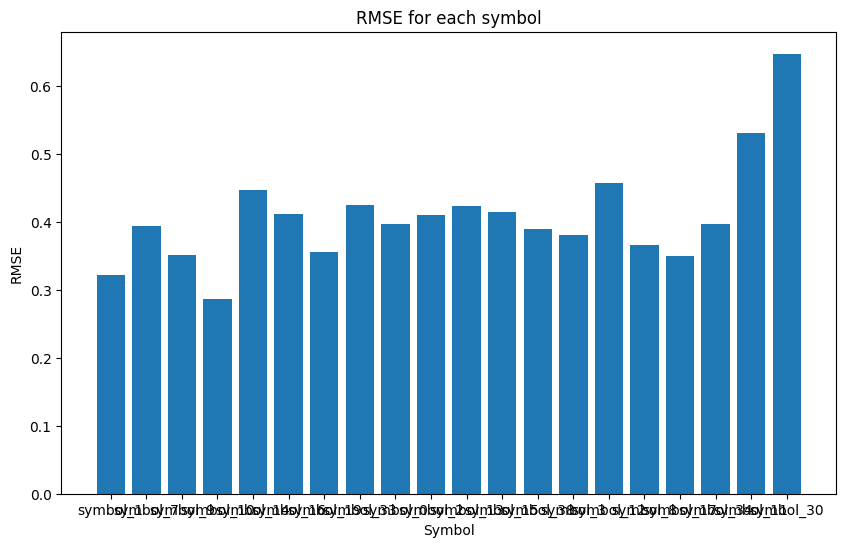

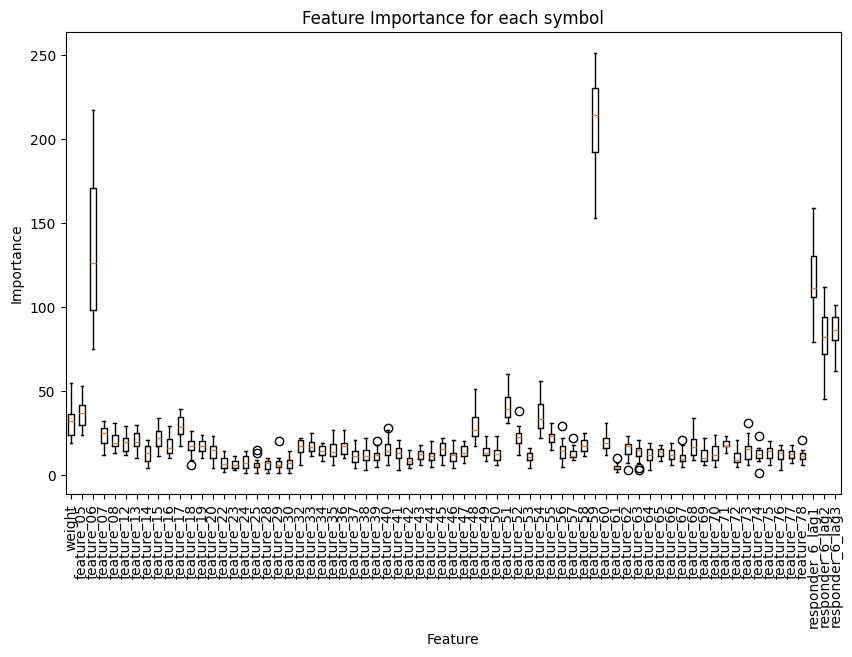

In [38]:
# create as many xgboost models as there are symbols and compare the results

rmse = {}
features_importances = {}
symbols = full_data['symbol_id'].unique().tolist()
    
for symbol in symbols:
    print(f"Predictions for symbol {symbol}")

    # Train XGBoost model and evaluate rmse
    model, rmse[f'symbol_{symbol}'] = train_model_xgboost(symbol, full_data)

    # save the feature importances
    importances = model.get_score(importance_type='weight')
    features_names = model.get_score(importance_type='weight').keys()

    for features in features_names:
        if features in features_importances:
            features_importances[f'{features}'].append(importances[features])
        else:
            features_importances[f'{features}'] = [importances[features]]
 
 # Plot RMSE Bar Chart and Feature Importance Boxplot

# RMSE Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(rmse.keys(), rmse.values())
plt.xlabel('Symbol')
plt.ylabel('RMSE')
plt.title('RMSE for each symbol')
plt.show()

# Feature Importance Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(features_importances.values())
plt.xticks(range(1, len(features_importances) + 1), features_importances.keys(), rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for each symbol')
plt.show()


## Building a VAE

In [ ]:
# Create class KaggleDataset which is a child of Dataset class from torch.util.data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class KaggleDataset(Dataset):
    
    def __init__(self, df):
        """
        Args:
            df (pd.DataFrame): DataFrame containing the data
        """
        # Store the preprocessed DataFrame in self.dataframe (for symbol 0)
        X, y = data_preprocess(df)
        self.dataframe = pd.concat([X, y], axis=1)

        # Extract the features for easier manipulation
        self.features = self.dataframe.values

        # Calculate mean and std for normalization
        self.mean = self.features.mean(axis=0)
        self.std = self.features.std(axis=0)

        # Apply normalization to features
        self.features = (self.features - self.mean) / self.std

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        # Return the item at index idx in the form of tensor
        features = torch.tensor(self.features[idx], dtype=torch.float32).to(device)
        return features

# Create a KaggleDataset object
dataset = KaggleDataset(full_data.copy())

# Then, the batch_size and input_dim were set. The dataset was divided into train and test datasets. Each of these was loaded into a DataLoader. The device was set to ‘cuda’ if available. 

In [19]:
# Define batchsize and input dimensions
batch_size = 64
input_dim = dataset.features.shape[1]
latent_dim = input_dim - 5
hidden_dim = (latent_dim + input_dim) // 2
# Define learning rate
learning_rate = 1e-3

# Split dataset into train and test without shuffle in the ratio of 80:20
train_dataset, test_dataset = random_split(dataset, [0.8,0.2])

# Use DataLoader for batching and shuffling
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # Latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 1)
        self.logvar_layer = nn.Linear(latent_dim, 1)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(1, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
            )
        
    # Encode function
    def encode(self, x):
        x = self.encoder(x)
        mean, log_var = self.mean_layer(x), self.logvar_layer(x)
        return mean, log_var
    
    # Add Reparameterization
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    # Decode function
    def decode(self, x):
        return self.decoder(x)

    # Forward Function
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
    
    # Reconstruct input from compressed form
    def reconstruction(self, mean, log_var):
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat


In [21]:
def loss_function(x, x_hat, mean, log_var):
    # Reproduction Loss
    reproduction_loss = nn.functional.mse_loss(x_hat, x)
    # KL Divergence Loss
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

# VAE Model created and stored in device
model = VAE(input_dim = input_dim,hidden_dim=hidden_dim,  latent_dim=latent_dim).to(device)

# Optimizer defined
optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(model, optimizer, epochs, device):
    
    # Set model to training mode
    model.train()
    
    # Loop for each epoch
    for epoch in range(epochs):
        overall_loss = 0
        
        # Iterate over the batches formed by DataLoader
        for batch_idx, x in enumerate(train_dataloader):
            x = x.to(device)
            
            # Reset Gradient
            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)
            
            # Calculate batch loss and then overall loss
            loss = loss_function(x, x_hat, mean, log_var)
            overall_loss += loss.item()
            
            # Backpropagate the loss and train the optimizer
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

# Train the model for 5 epochs
train(model, optimizer, epochs=5, device=device)

In [ ]:
def predict(model, test_dataloader=test_dataloader):
    
    # Set model to evaluation mode
    model.eval()
    dataset_size = 0
    
    # Set up torch so there is no gradient upgrade
    with torch.no_grad():
        overall_loss=0
        all_mean = None
        all_log_var = None
        
        # Iterate over batches of test dataset
        for batch_idx, x in enumerate(test_dataloader):
            
            # Get reconstructed value, mean and log_var
            x_hat, mean, log_var  = model(x)
            
            # Calculate loss
            loss = loss_function(x, x_hat, mean, log_var)
            
            # Add mean and log_var to arrays
            if all_mean is not None:
                all_mean = torch.cat((all_mean, mean))
                all_log_var = torch.cat((all_log_var, log_var))
            else:
                all_mean = mean
                all_log_var = log_var
            
            # Add loss 
            overall_loss += loss.item()
            
            # Calculate the size of the dataset
            size_batch = x.element_size() * x.numel()
            dataset_size += size_batch

        # Calculate the size after compression of the dataset
        compressed_size = (all_mean.element_size() * all_mean.numel()) + (all_log_var.element_size() * all_log_var.numel())

        print("\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
        print(f"\tDataset Size: {dataset_size} \n\tCompressed Size: {compressed_size}")
        print("\tCompression Ratio: ", compressed_size/dataset_size)

        return all_mean, all_log_var
    
# Predict the values for test dataset and calculate compression ratio
mean,var = predict(model)

# Reconstruct the input from compressed form
x_hat = model.reconstruction(mean, var)

# reparameterization of x_hat to obtain the reconstructed values of the input

df_hat = pd.DataFrame(x_hat.detach().numpy(), columns=dataset.dataframe.columns)


In [ ]:
from itertools import product

# Build a cross-validation grid search for our VAE model

# Define the hyperparameters to search
hyperparameters = {
    'hidden_dim': [input_dim - 1 , input_dim - 3],
    'latent_dim': [input_dim - 10, input_dim - 20],
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [64, 128]
}

# Define the number of epochs
epochs = 5

# Define the number of folds for cross-validation
n_splits = 2

# Create a list of all hyperparameter combinations
keys, values = zip(*hyperparameters.items())
combinations = [dict(zip(keys, v)) for v in product(*values)]

# Create a list of models and their corresponding hyperparameters
models = []
for combination in combinations:
    model = VAE(input_dim=input_dim, hidden_dim=combination['hidden_dim'], latent_dim=combination['latent_dim']).to(device)
    optimizer = Adam(model.parameters(), lr=combination['learning_rate'])
    models.append((model, optimizer, combination))

# Cross-validation for each model
for model, optimizer, combination in models:
    print(f"Training model with hyperparameters: {combination}")
    for fold, (train_idx, test_idx) in enumerate(TimeSeriesSplit(n_splits=n_splits).split(dataset)):
        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        test_dataset = torch.utils.data.Subset(dataset, test_idx)
        train_dataloader = DataLoader(train_dataset, batch_size=combination['batch_size'], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=combination['batch_size'], shuffle=False)
        train(model, optimizer, epochs, device=device)
        mean, var = predict(model, test_dataloader)
        print(f"Model with hyperparameters {combination} and fold {fold} has been trained and evaluated.")
        print("-------------------------------------------------------------")

## XGBoost based model on all symbols

[0]	train-rmse:0.63954	eval-rmse:0.76674
[10]	train-rmse:0.32443	eval-rmse:0.39955
[20]	train-rmse:0.31694	eval-rmse:0.39155
[30]	train-rmse:0.31420	eval-rmse:0.39034
[40]	train-rmse:0.31218	eval-rmse:0.39001
[50]	train-rmse:0.31043	eval-rmse:0.38992
[55]	train-rmse:0.30961	eval-rmse:0.39014
Final RMSE: 0.3901


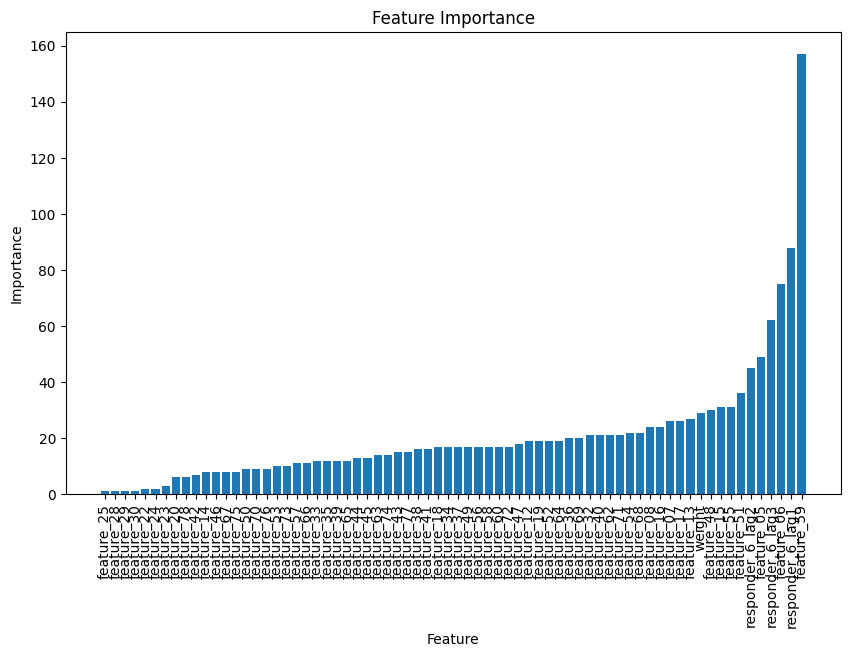

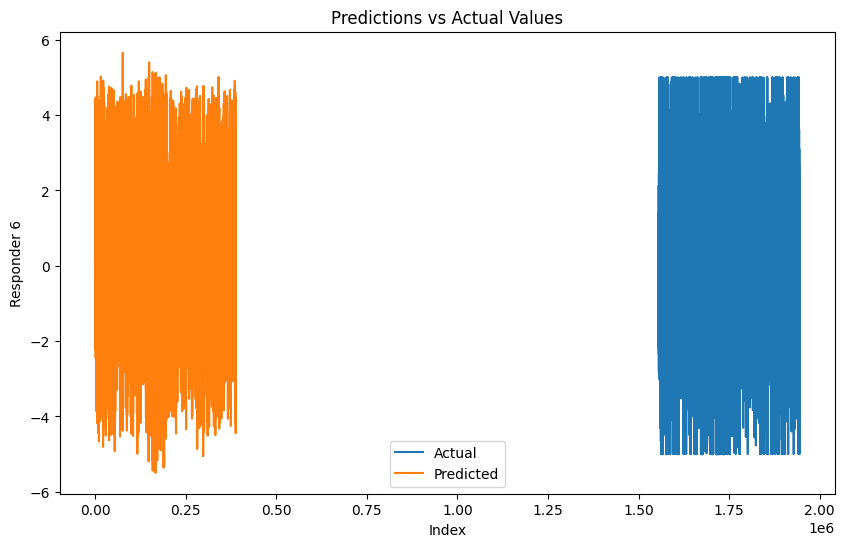

In [39]:
# create a single xgboost model for all symbols
max_lag = 4

# create the lagged responder_6 columns
for lag in range(1, max_lag + 1):
    full_data[f'responder_6_lag{lag}'] = full_data.groupby('symbol_id')['responder_6'].shift(lag)

# drop rows with NaN
full_data.dropna(subset=[f'responder_6_lag{lag}' for lag in range(1, max_lag + 1)])

# separate features and target

exclude_cols = ['date_id', 'time_id'] + [f'responder_{i}' for i in range(0, 9)]
X = full_data.drop(columns=exclude_cols)
y = full_data['responder_6']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# train the model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=10, verbose_eval=10)

# predict the test set
y_pred = model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE: {rmse:.4f}")

# plot feature importance in ascending order
sorted_importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1])}

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.bar(sorted_importances.keys(), sorted_importances.values())
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Responder 6')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()

## XGboost benchmarking differents dimension reduction methods

In [ ]:
# disable the warnings
import warnings
warnings.filterwarnings('ignore')

X,y = data_preprocess(full_data.copy())

In [30]:
# Define an Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
        )
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

    def train_model(self, training_set, num_epochs = 10, batch_size=64):  
        for epoch in range(num_epochs):
            self.train()
            self.optimizer.zero_grad()
            X_reconstructed, X_latent = self(training_set)
            loss = self.criterion(X_reconstructed, training_set)
            loss.backward()
            self.optimizer.step()

Model xgb has MSE 0.1731 and Time Complexity 3.9276 without dimensionality reduction
Model xgb has MSE 0.2004 and Time Complexity 2.2022 with PCA
Model xgb has MSE 0.3117 and Time Complexity 4.5679 with Autoencoder
------------------------------------------------------------------------
Model linear has MSE 0.1521 and Time Complexity 0.3663 without dimensionality reduction
Model linear has MSE 0.1739 and Time Complexity 0.2584 with PCA
Model linear has MSE 0.3597 and Time Complexity 2.3849 with Autoencoder
------------------------------------------------------------------------


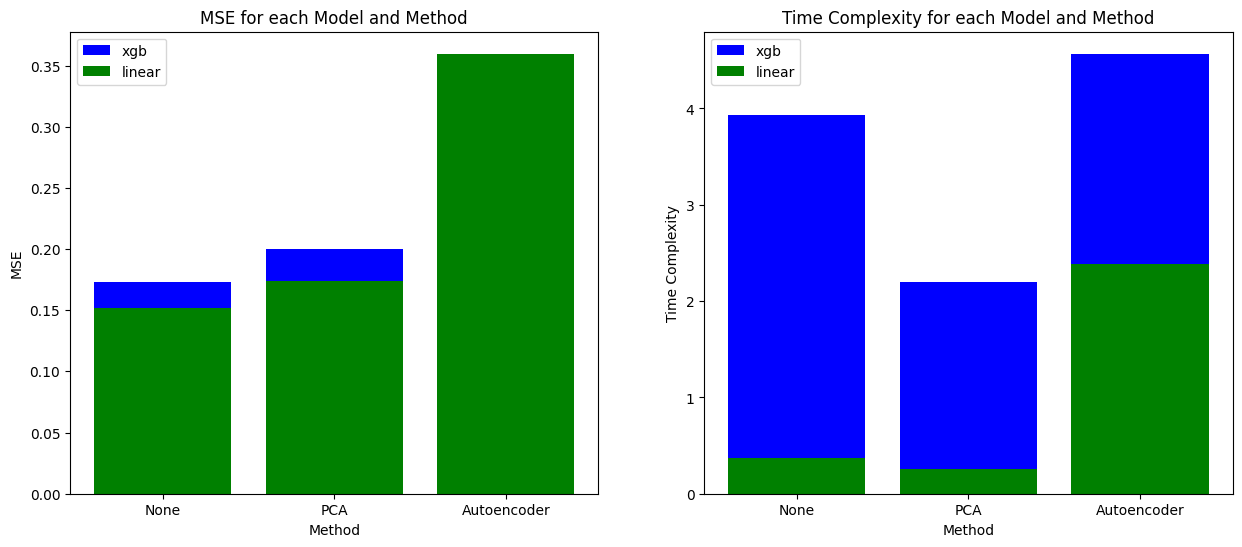

In [36]:
import time as time

# dimensionality reduction with PCA, and Autoencoder
dim = X.shape[1] // 2

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Fonction pour réduire la dimensionnalité et retourner les nouvelles données d'entrainement et de test
def reduce_dimensionality(X_train, X_test, dim, method):
    if method == 'pca':
        pca = PCA(n_components=dim)
        X_train_reduced = pca.fit_transform(X_train)
        X_test_reduced = pca.transform(X_test)
    elif method == 'autoencoder':
        autoencoder = Autoencoder(input_dim=X_train.shape[1], latent_dim=dim)
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        autoencoder.train_model(num_epochs=10, training_set=X_train_tensor)
        autoencoder.eval()
        with torch.no_grad():
            _, X_train_latent = autoencoder(X_train_tensor)
            _, X_test_latent = autoencoder(X_test_tensor)
        X_train_reduced = X_train_latent.numpy()
        X_test_reduced = X_test_latent.numpy()
    else:
        X_train_reduced, X_test_reduced = X_train, X_test
    
    return X_train_reduced, X_test_reduced

# Fonction pour évaluer les performances du modèle
def evaluate_model(X_train, X_test, y_train, y_test, model, method=None):
    start = time.time()
    X_train_reduced, X_test_reduced = reduce_dimensionality(X_train, X_test, dim, method)
    model.fit(X_train_reduced, y_train)
    end = time.time()
    
    y_pred = model.predict(X_test_reduced)
    mse = mean_squared_error(y_test, y_pred)
    training_time = end - start
    
    return mse, training_time

# Définir les modèles à évaluer
models = {
    'xgb': xgb.XGBRegressor(),
    'linear': LinearRegression(),
}

# Create a graphic table that shows the MSE and time_complexity Benchmark for each model and each dimensionality reduction method
# Create a DataFrame to store the results

results = pd.DataFrame(columns=['Model', 'Method', 'MSE', 'Time Complexity'])

for name, model in models.items():
    mse,time_ = evaluate_model(X_train, X_test, y_train, y_test, model)
    mse_pca,time_pca = evaluate_model(X_train, X_test, y_train, y_test, model, method='pca')
    mse_autoencoder,time_autoencoder = evaluate_model(X_train, X_test, y_train, y_test, model, method='autoencoder')
    # concatenate the results
    results = pd.concat([results, pd.DataFrame({'Model': [name, name, name], 'Method': ['None', 'PCA', 'Autoencoder'], 'MSE': [mse, mse_pca, mse_autoencoder], 'Time Complexity': [time_, time_pca, time_autoencoder]})])
    print(f"Model {name} has MSE {mse:.4f} and Time Complexity {time_:.4f} without dimensionality reduction")
    print(f"Model {name} has MSE {mse_pca:.4f} and Time Complexity {time_pca:.4f} with PCA")
    print(f"Model {name} has MSE {mse_autoencoder:.4f} and Time Complexity {time_autoencoder:.4f} with Autoencoder")
    print("------------------------------------------------------------------------")

# Evaluate the models and their performance in mse and time complexity with multiple bar charts aside
# A color for each model
colors = ['blue', 'green']

# Create a figure and axis
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Create a bar chart for MSE
for i, model in enumerate(models.keys()):
    mse = results[results['Model'] == model]['MSE']
    method = results[results['Model'] == model]['Method']
    ax[0].bar(method, mse, color=colors[i], label=model)

# Set the title and labels
ax[0].set_title('MSE for each model and method')
ax[0].set_xlabel('Method')
ax[0].set_ylabel('MSE')
ax[0].legend()

# Create a bar chart for Time Complexity
for i, model in enumerate(models.keys()):
    time_complexity = results[results['Model'] == model]['Time Complexity']
    method = results[results['Model'] == model]['Method']
    ax[1].bar(method, time_complexity, color=colors[i], label=model)

# Set the title and labels
ax[1].set_title('Time Complexity for each model and method')
ax[1].set_xlabel('Method')
ax[1].set_ylabel('Time Complexity')
ax[1].legend()

# Show the plot
plt.show()


## SUAVE-ML VAE

In [44]:
X,y = data_preprocess(full_data.copy(), symbol=0)

In [45]:
from suave import SuaveClassifier

# Preparing data for SuaveClassifier
# transforming the target variable into a 3 bins classification problem
Y = pd.concat([y, pd.qcut(y, 3, labels=False)], axis=1, keys=['responder_6', 'target'])
target = pd.DataFrame(Y['target'])
# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size=0.2, shuffle=False)
# convert the data into dataframes
Y_train = pd.DataFrame(Y_train, columns=['target'])
Y_test = pd.DataFrame(Y_test, columns=['target'])

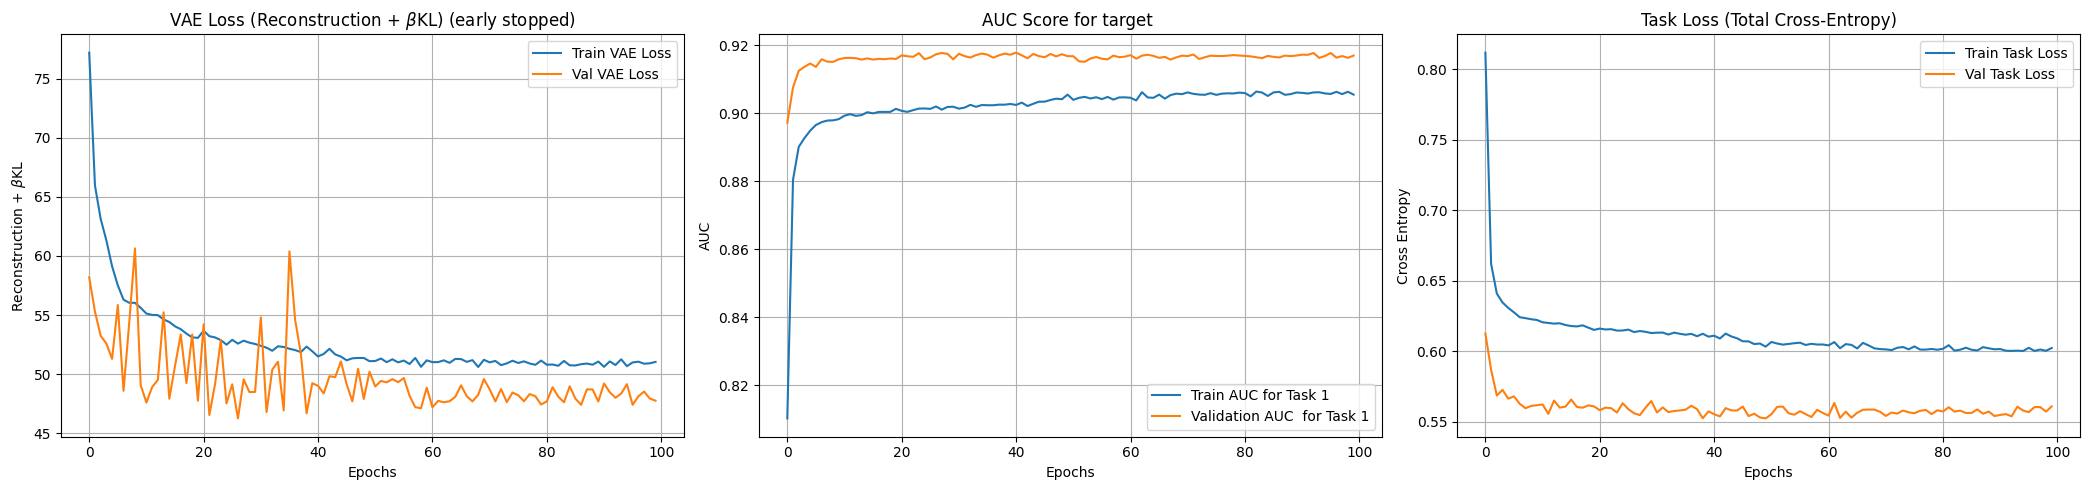

Training: 100%|██████████| 100/100 [1:06:19<00:00, 39.80s/epoch, VAE(t)=51.032, VAE(v)=47.750, AUC(t)=[0.905], AUC(v)=[0.917]]


SuaveClassifier(
  (vae): VAE(
    (encoder): Encoder(
      (body): Sequential(
        (0): Linear(in_features=71, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=64, out_features=49, bias=True)
        (5): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): LeakyReLU(negative_slope=0.01)
        (7): Dropout(p=0.3, inplace=False)
      )
      (latent_mu): Linear(in_features=49, out_features=35, bias=True)
      (latent_logvar): Linear(in_features=49, out_features=35, bias=True)
    )
    (decoder): Decoder(
      (body): Sequential(
        (0): Linear(in_features=35, out_features=49, bias=True)
        (1): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=49, out_features=64, bias=True)
        (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): LeakyReLU(negative_slope=0.01)
        (7): Dropout(p=0.3, inplace=False)
      )
      (output_layer): Linear(in_features=64, out_features=71, bias=True)
    )
  )
  (predictor): MultiTaskPredictor(
    (task_heads): ModuleList(
      (0): Sequential(
        (0): ResidualBlock(
          (fc): Linear(in_features=35, out_features=64, bias=True)
          (projection): Linear(in_features=35, out_features=64, bias=True)
          (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): Linear(in_features=64, out_features=3, bias=True)
      )
    )
  )
)

In [46]:

# Instantiate the model
suave_model = SuaveClassifier(input_dim=X_train.shape[1],             # Input feature dimension
                        task_classes=[len(Y_train['target'].unique())],   # Number of binary classification tasks
                        latent_dim=X_train.shape[1]//2                 # Latent dimension
                        )

# Fit the model on training data
suave_model.fit(X_train, Y_train, epochs=100, animate_monitor=True, verbose=1)

NameError: name 'suave_model' is not defined

In [2]:
import joblib

# save the model
joblib.dump(suave_model, "suave-model.pkl")

NameError: name 'suave_model' is not defined

In [28]:
suave_model = joblib.load("suave-model.pkl")

In [ ]:
# Get the latent representation of the data
X_train_latent_SUAVE = model.transform(X_train)
X_test_latent_SUAVE = model.transform(X_test)

# Fit a linear regression model on the latent representation
linear_model = LinearRegression()
linear_model.fit(X_train_latent_SUAVE, Y_train)

# Predict the target variable on the test set
y_pred = linear_model.predict(X_test_latent_SUAVE)

# Calculate the mean squared error
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Responder 6')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()